# My meanshift algorithm



In [1]:
import torch, math
from fastcore.test import test_eq, test_close
import matplotlib.pyplot as plt

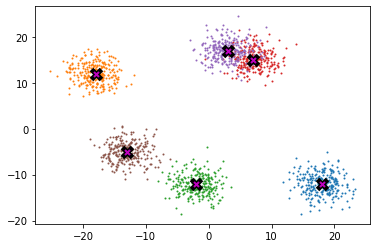

In [2]:
n_clusters=6
n_samples =250

# To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

centroids = torch.randint(-35, 35, (n_clusters, 2)).float()

from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

slices = [sample(c) for c in centroids]
data = torch.cat(slices)

# Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

def plot_data(centroids, data, n_samples):
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], s=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        plt.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)

plot_data(centroids, data, n_samples)

# Compute distances

In [3]:
points = dict(
    a00=(-1,1),
    a01=(0,1),
    a02=(1,1),
    a10=(-1,0),
    a11=(0,0),
    a12=(1,0)
)
t_points = torch.tensor(list(points.values()))
names = points.keys()
points, names, t_points

({'a00': (-1, 1),
  'a01': (0, 1),
  'a02': (1, 1),
  'a10': (-1, 0),
  'a11': (0, 0),
  'a12': (1, 0)},
 dict_keys(['a00', 'a01', 'a02', 'a10', 'a11', 'a12']),
 tensor([[-1,  1],
         [ 0,  1],
         [ 1,  1],
         [-1,  0],
         [ 0,  0],
         [ 1,  0]]))

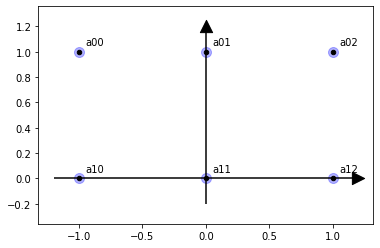

In [4]:
plt.scatter(*t_points.t(), s=100, c='blue', alpha=.3)
plt.scatter(*t_points.t(), s=20, c='k')
plt.hlines(0, -1.2, 1.2, 'k')
plt.vlines(0, -.2, 1.2, 'k')
plt.scatter(1.2, 0, s=150, marker='>', c='k')
plt.scatter(0, 1.2, s=150, marker='^', c='k')
for name, coord in points.items():
    plt.text(coord[0]+.05, coord[1]+.05, name)
plt.axis('equal');

In [5]:
sq2, sq5 = math.sqrt(2), math.sqrt(5)
expected_dist = torch.tensor([
    [0, 1, 2, 1, sq2, sq5],
    [1, 0, 1, sq2, 1, sq2],
    [2, 1, 0, sq5, sq2, 1],
    [1, sq2, sq5, 0, 1, 2],
    [sq2, 1, sq2, 1, 0, 1],
    [sq5, sq2, 1, 2, 1, 0]
])
expected_dist

tensor([[0.0000, 1.0000, 2.0000, 1.0000, 1.4142, 2.2361],
        [1.0000, 0.0000, 1.0000, 1.4142, 1.0000, 1.4142],
        [2.0000, 1.0000, 0.0000, 2.2361, 1.4142, 1.0000],
        [1.0000, 1.4142, 2.2361, 0.0000, 1.0000, 2.0000],
        [1.4142, 1.0000, 1.4142, 1.0000, 0.0000, 1.0000],
        [2.2361, 1.4142, 1.0000, 2.0000, 1.0000, 0.0000]])

In [6]:
def dist(tensor): return (tensor[None] - tensor[:, None]).square().sum(-1).sqrt()

In [7]:
test_close(dist(t_points), expected_dist)

# Gaussian kernel

In [8]:
def kernel(m, bw): return torch.exp(-.5 * (m/bw).square()) / (bw * math.sqrt(2 * math.pi))

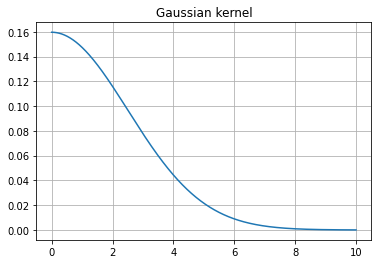

In [9]:
x = torch.linspace(0, 10, 1000)
plt.plot(x, kernel(x, 2.5))
plt.title('Gaussian kernel');
plt.grid(True)

# Minshift

In [10]:
def meanshift(X, bw=2.5):
    for _ in range(5):
        weights = kernel(dist(X), bw)
        X = (weights[..., None] * X[None]).sum(1)
        X = X / weights.sum(-1, keepdim=True)
    return X

In [11]:
X = data.clone()

In [12]:
%timeit _ = meanshift(X)

100 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
X = data.clone()
X = X.cuda()

In [14]:
%timeit _ = meanshift(X)

3.36 ms ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


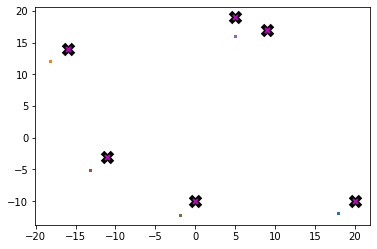

In [15]:
X = data.clone().cuda()
X = meanshift(X)
plot_data(centroids+2, X.to('cpu'), n_samples)